In [46]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import datetime
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from geo_utils import (
    radius_search,
    k_nearest_search,
    get_geometry_neighbors,
)
from stat_utils import bootstrap_statistic
from utils import GCMTcatalog
from data import MidAtlanticRidge, GIA


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
font = {"size": 9}
mpl.rc("font", **font)
mpl.rc("figure", dpi=300)
color_map = mpl.cm.get_cmap('RdYlBu_r')

/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_49730/2065924816.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = mpl.cm.get_cmap('RdYlBu_r')


## Required Files and Metadata

In [48]:

data_dir = "data/"

plate_boundary_metadata = {
    "filename": data_dir + "plate_boundaries/PB2002_boundaries.shp",
    "boundary_names": ["NA-EU", "EU-NA"],
    "stepsize": 50000, # meters (the point spacing of the plate boundary)
}

earthquake_catalog_metadata = {
    "ISC": {
        "filename": data_dir + "global_M4.csv",
        "query":{
            "minimum_magnitude": 4.0,
            "starttime": "1960-01-01",
            "endtime": "2022-01-01",
            "reload":False,
        },
        "buffer_km": 100,
    },
    "gCMT": {
        "filename": data_dir + "gcmt.csv",
    },
    "mag_completeness":4.0, # change this to avoid re-downloading the catalog
}

earthquake_metadata = earthquake_catalog_metadata["ISC"]  # Option here

AVAILABLE_STRAIN_RATE_FILES = {
    "july25_thick": "Jul25/yearly_strain_rate_tensors_l90ump5lm3_smoothice_S.mat",
    "july25_long_term": "Jul25/presentday_strain_rate_tensors_l90ump5lm3_ICE6G_S_fixbeta.mat",
}

GrGIA_strain_metadata = {
    "filename": data_dir + AVAILABLE_STRAIN_RATE_FILES["july25_thick"],
    "data_key": "strain_out", # unfortunately this is not consistent accross datasets.
    "data_config":{
        "starttime": 1993,
        "endtime": 2020,
        "number_of_times": 27,
        "latitude_range": [-90, 90],
        "number_of_latitudes": 510,
        "longitude_range": [-180, 180],
        "number_of_longitudes": 1022,
    },
    "strain_units": [1e-9, "s^{-1}"],  # scale, unit
    "strain_positive_convention": "compression",
    "longterm_filename": data_dir + AVAILABLE_STRAIN_RATE_FILES["july25_long_term"], 
}

crs = ccrs.NorthPolarStereo()

region_metadata = {
    "bounding_box": [-180, 55, 10, 90],
    "exclude_iceland":True,
    "iceland_bounds": [(-25.5, 63), (-25.5, 67), (-12.5, 67), (-12.5, 63), (-25.5, 63)],
}

### North atlantic spreading ridge (datasets)

In [60]:

# plate boundary data:
MAR = MidAtlanticRidge(
    **plate_boundary_metadata,
    **region_metadata,
)

# earthquake data (ISC):
earthquakes = MAR.get_earthquake_catalog(**earthquake_catalog_metadata["ISC"])
earthquakes.mag_completeness = earthquake_catalog_metadata["mag_completeness"]

# earthquake focal mechanism data (gCMT): 
gcmt_earthquakes = GCMTcatalog(earthquake_catalog_metadata["gCMT"]["filename"])
gcmt_earthquakes =  MAR.get_earthquake_catalog(gcmt_earthquakes)

# GIA model output:
gia = GIA(**GrGIA_strain_metadata)

date_range = pd.date_range(
    start=datetime.datetime(GrGIA_strain_metadata['data_config']["starttime"], 1, 1),
    end=datetime.datetime(GrGIA_strain_metadata['data_config']["endtime"], 1, 1),
    periods=GrGIA_strain_metadata['data_config']["number_of_times"]+1, # I honestly don't remember why the +1 is here
)

/Users/kdascher/miniforge3/envs/grGIS_seismicity/lib/python3.10/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/kdascher/Documents/Documents/Berkeley/Projects/Exploratory_projects/GrGIA/GrGIA_seismicity/utils.py:919: UserWarning: Using existing data/global_M4.csv
  warnings.warn(f"Using existing {filename}")
/Users/kdascher/Documents/Documents/Berkeley/Projects/Exploratory_projects/GrGIA/GrGIA_seismicity/utils.py:925: UserWarning: 2108 NaN values found in catalog. Removing rows with NaN values.
  warnings.warn(


# SOPHIE THIS IS HOW YOU GET THE EARTHQUAKE DATA


In [ ]:
MAR._raw_earthquake_catalog.plot_map()
MAR._raw_earthquake_catalog.catalog.head()

,time,lat,lon,depth,mag
649025,1960-01-01 23:12:30.999999936,56.09,163.02,0.0,5.4
649024,1960-01-02 03:21:48.000000000,-17.68,-69.21,154.0,6.2
649023,1960-01-02 05:06:57.000000000,3.03,95.96,0.0,5.8
649022,1960-01-02 06:59:36.000000000,55.91,163.25,0.0,5.6
649021,1960-01-02 12:21:53.000000000,-55.63,-1.83,0.0,6.4


/Users/kdascher/miniforge3/envs/grGIS_seismicity/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


### Relational information

In [50]:
# strain -> earthquake
earthquake_time_dt = pd.to_datetime(earthquakes.catalog.time).dt

strain = gia.query(
    earthquake_time_dt.year + earthquake_time_dt.dayofyear / 365 - 1,
    earthquakes.catalog.lat.to_numpy(),
    earthquakes.catalog.lon.to_numpy(),
)


earthquakes.catalog["gia_strain_tensor"] = [
    strain[i, :, :] for i in range(len(earthquakes))
]

# boundary geometry -> earthquake:
indices = k_nearest_search(
    np.array([MAR.merged_geometry_meters.xy[1], MAR.merged_geometry_meters.xy[0]]).T,
    earthquakes.catalog[["lat", "lon"]].values,
)
earthquakes.catalog["distance_along_boundary"] = (
    indices * plate_boundary_metadata["stepsize"]
)

segment = k_nearest_search(
    np.array([MAR.merged_geometry_meters.xy[1], MAR.merged_geometry_meters.xy[0]]).T,
    earthquakes.catalog[["lat", "lon"]].values,
    k=2,
)
earthquakes.catalog["plate_boundary_segment"] = [
    segment[i, :] for i in range(segment.shape[0])
]

# ISC -> gCMT
indices = k_nearest_search(
    gcmt_earthquakes.catalog[["lat", "lon"]].values,
    earthquakes.catalog[["lat", "lon"]].values,
    k=1,
)

# gCMT -> ISC
earthquakes.catalog["proxy_mechanism"] = [
    gcmt_earthquakes.catalog["mechanism"].values[i] for i in indices.squeeze()
]


In [51]:
def unravelled_grid(t, lat, lon):
    time_grid, lat_grid = [q.ravel() for q in np.meshgrid(t, lat)]
    _, lon_grid = [q.ravel() for q in np.meshgrid(t, lon)]
    return np.column_stack([time_grid, lat_grid, lon_grid])


plate_boundary_unravelled_grid = unravelled_grid(
    (date_range.year + (date_range.dayofyear - 1) / 365).values[1:],  # time,
    MAR.merged_geometry_meters.xy[1],  # latitudes of the plate boundary
    MAR.merged_geometry_meters.xy[0],  # longitudes of the plate boundary
)

strain_at_plate_boundary = gia.query(
    plate_boundary_unravelled_grid[:, 0],
    plate_boundary_unravelled_grid[:, 1],
    plate_boundary_unravelled_grid[:, 2],
)

strain_at_plate_boundary_grid = np.reshape(
    strain_at_plate_boundary,
    (len(MAR.merged_geometry_meters.xy[0]), len(date_range) - 1, 3, 3),
)

normal_strain_grid = []
for i in np.arange(strain_at_plate_boundary_grid.shape[0] - 1):
    normal_strain_row = []
    for j in np.arange(strain_at_plate_boundary_grid.shape[1]):
        normal_strain_row.append(
            gia.get_normal_strain_latlon(
                epsilon=strain_at_plate_boundary_grid[i, j, :, :],
                latitude_1=MAR.merged_geometry_meters.xy[1][i],
                longitude_1=MAR.merged_geometry_meters.xy[0][i],
                latitude_2=MAR.merged_geometry_meters.xy[1][i + 1],
                longitude_2=MAR.merged_geometry_meters.xy[0][i + 1],
            ).squeeze()
        )
    normal_strain_grid.append(normal_strain_row)
normal_strain_grid = np.array(normal_strain_grid)

In [52]:
# plot I2 on a lat, lon grid

lats = np.linspace(50, 85, 200)
lons = np.linspace(-50, 30, 200)

lat_grid, lon_grid = np.meshgrid(lats, lons)

lat = lat_grid.flatten()
lon = lon_grid.flatten()

e_grid = gia.query(
    (date_range.year + (date_range.dayofyear - 1) / 365).values[-1] * np.ones_like(lat),
    lat,
    lon,
)


I1 = [gia.I1(e[:2, :2]) for e in e_grid]
I1 = np.array(I1).reshape(lat_grid.shape)

## Variations in time and space:

In [53]:
catalog = earthquakes.catalog

rate_grid = []
b_time = []
all_indices = []

delta_t = date_range[1] - date_range[0]
print(delta_t)

# Space-time rate:
for t1, t2 in zip(date_range[:-1], date_range[1:]):
    sub_catalog = catalog[(catalog.time < t2) & (catalog.time > t1)]
    indices = get_geometry_neighbors(
        sub_catalog,
        MAR.merged_geometry_meters,
        fun=radius_search,
        kwarg={"radius":  plate_boundary_metadata["stepsize"]/1e3},
    )
    all_indices.append(indices)
    rate_grid.append([len(i) for i in indices])

rate_grid = np.array(rate_grid).T

365 days 05:20:00


# Greenland Icesheet Glacial Isostatic Ajustment model output

We can next consider how these rates of seismicity relate to changes in Iceshelf loading over time.

/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_49730/1752515477.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('RdYlBu_r'))


[Text(0, 0.5, 'Number of earthquakes'), (0.0, 241.5)]

/Users/kdascher/miniforge3/envs/grGIS_seismicity/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/kdascher/miniforge3/envs/grGIS_seismicity/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


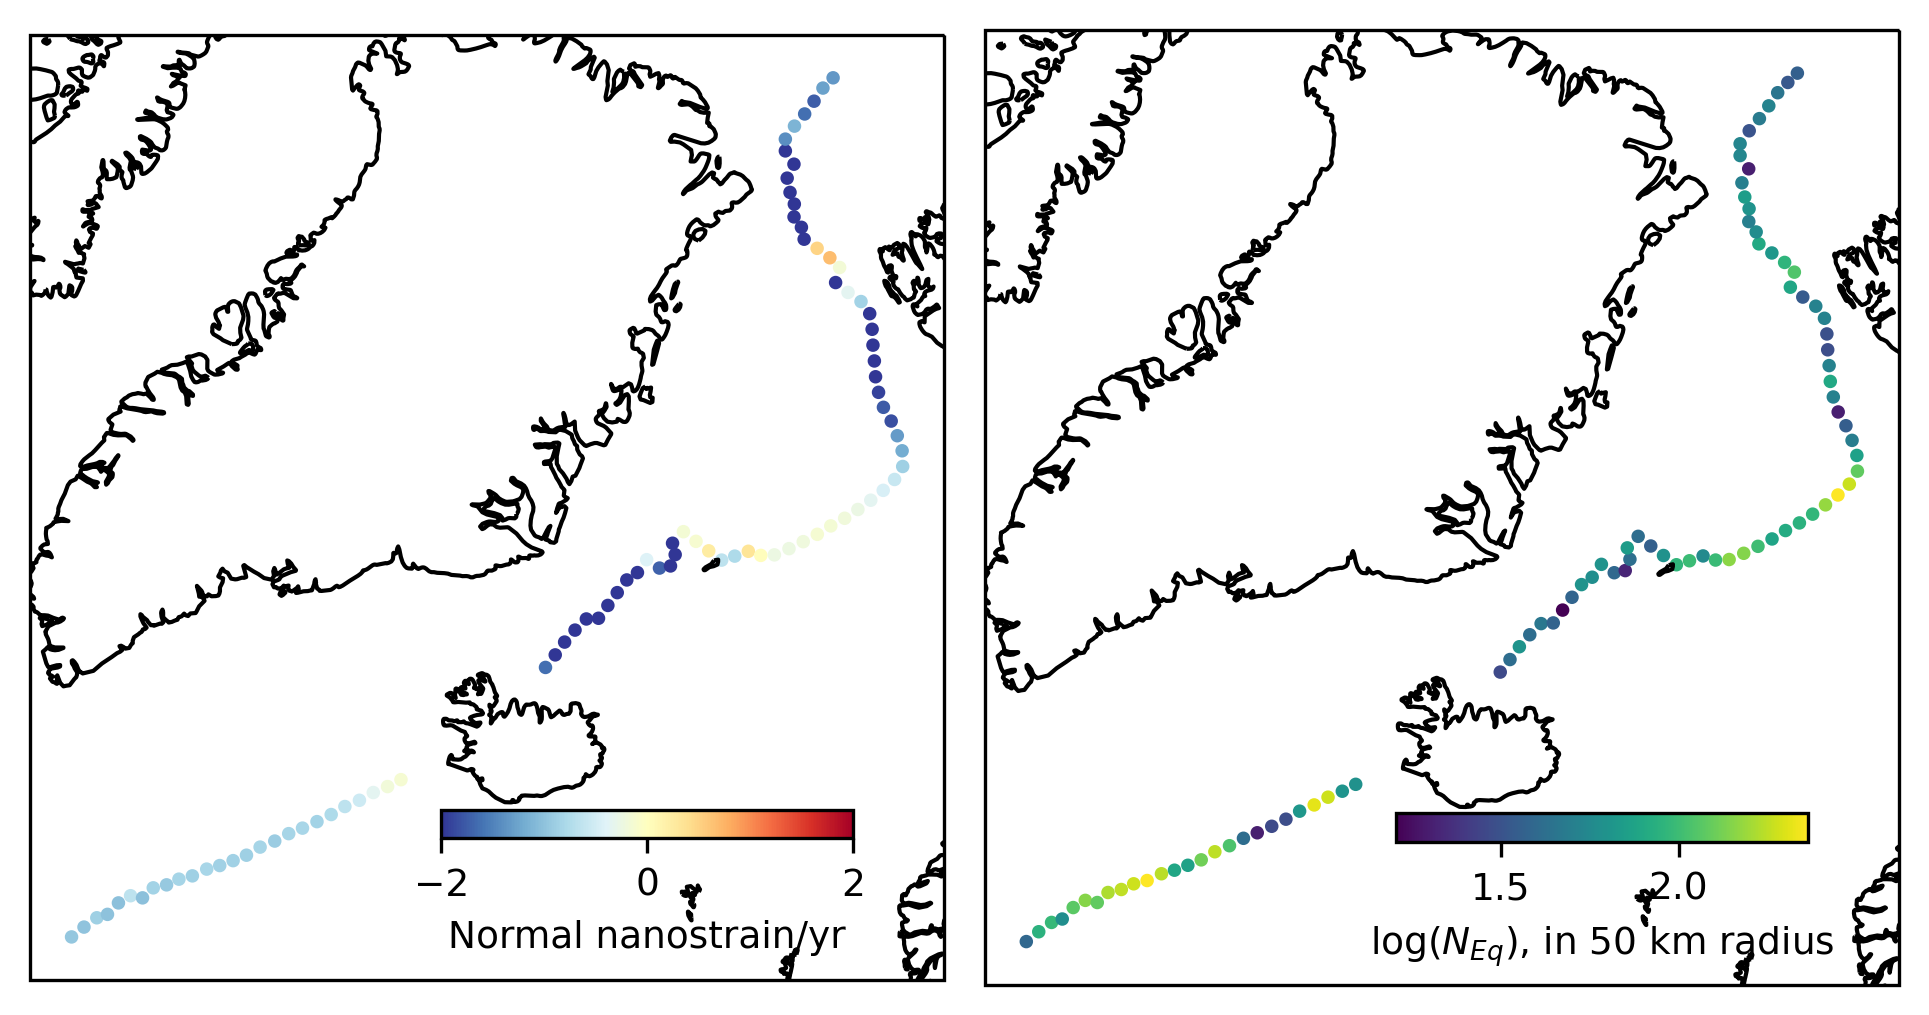

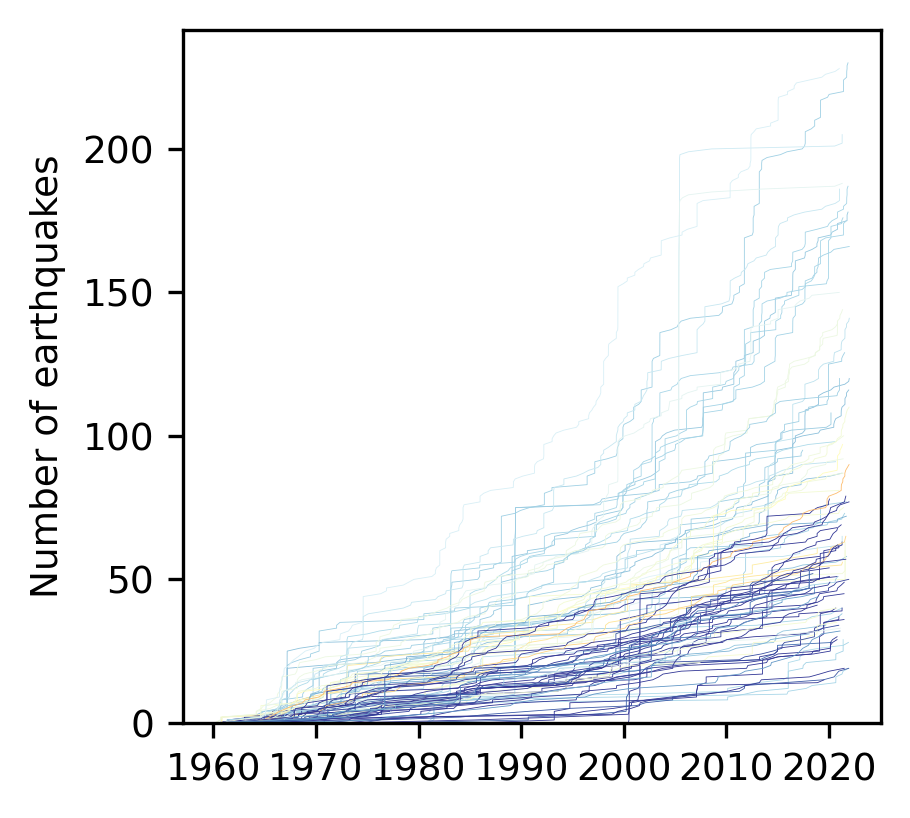

In [54]:

crs = ccrs.NorthPolarStereo()
fig, AX = plt.subplots(1,2,subplot_kw=dict(projection=crs), figsize=(6.5, 4), dpi=300)

ax=AX[0]
color_range = [-2, 2]
bdr = ax.scatter(
    MAR.merged_geometry_meters.xy[0][:-1], MAR.merged_geometry_meters.xy[1][:-1], c=-np.mean(normal_strain_grid, axis=1), s=5, 
    transform=ccrs.PlateCarree(), cmap="RdYlBu_r", vmin=color_range[0], vmax=color_range[1])
ax.coastlines()


RADIUS = 50  # km
indices = get_geometry_neighbors(
    catalog, MAR.merged_geometry_meters, fun=radius_search, kwarg={"radius": RADIUS}
)


axins1 = ax.inset_axes(
    [0.45,0.15,0.45,0.03],
)

fig.colorbar(
    bdr, 
    cax=axins1,
    label="Normal nanostrain/yr",
    orientation="horizontal",
)

ax = AX[1]
RADIUS = 50  # km
indices = get_geometry_neighbors(
    catalog, MAR.merged_geometry_meters, fun=radius_search, kwarg={"radius": RADIUS}
)
rate = [len(i) for i in indices]

bdr = ax.scatter(
    *MAR.merged_geometry_meters.xy, c=np.log10(rate), s=5, transform=ccrs.PlateCarree()
)
ax.coastlines()

axins1 = ax.inset_axes(
    [0.45,0.15,0.45,0.03],
)


fig.colorbar(
    bdr,
    cax=axins1, 
    orientation="horizontal",
    label=r"$\log(N_{Eq})$" + f", in {RADIUS} km radius",
)

norm = mpl.colors.Normalize(vmin=color_range[0], vmax=color_range[1])
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('RdYlBu_r'))

plt.tight_layout()

fig, ax = plt.subplots(figsize=(3,3), dpi=300)
for i, zone in enumerate(indices[:-1]):
    color_value = -np.mean(normal_strain_grid, axis=1)[i]
    ax.plot(np.sort(catalog.time.values[zone]), np.arange(len(zone)), lw=0.2, c=cmap.to_rgba(color_value))

ax.set(
    ylabel='Number of earthquakes',
    ylim=(0, ax.get_ylim()[1])
)


Figure: Spatial variations in the normal strain assuming a vertical plate boundary.

Question: How does long term GIA play into this? Could that be the main driver of this correspondence? Alternatively, could there be some geological reason for the earthquakes rate to be low near iceland and higher as you move away?

**Figure**: Comparison of the PDF for the rate of earthquake during periods with negative and positive vertical strain along the plate boundary. I find it diffucult to interpret a meaningful signal from this alone.

In [55]:
#Get plate rates to normalize eq rate by

NA_pole = [48.709, -78.167, 0.7486]  # deg/MA - DeMets et al. [1994]
EU_pole = [61.066, -85.819, 0.8591]  # deg/MA - DeMets et al. [1994]

def cartesian(p):
    return np.array([
        p[:, 2] * np.cos(p[:, 0]) * np.cos(p[:, 1]),
        p[:, 2] * np.cos(p[:, 0]) * np.sin(p[:, 1]),
        p[:, 2] * np.sin(p[:, 0]),
    ])

def get_spreading_rate(
    lat: np.ndarray = None,
    lon: np.ndarray = None,
    pole1: list[float, float, float] = NA_pole,
    pole2: list[float, float, float] = EU_pole,
) -> np.ndarray:
    """Gets the relative plate rate at a plate boundary for each lat lon pair given two euler poles

    The `pole` contains the **** lon, lat **** and angular roation rate (assumed to be in deg/MA). 
    
    Note that a relatively exhaustive list of pole can be found in the following link:
    http://peterbird.name/oldFTP/PB2002/PB2002_poles.dat.txt

    Returns the spreading rate in km/Ma (or, equivalently mm/yr)

    """

    pole1, pole2, lat, lon = map(np.radians, [pole1, pole2, lat, lon])

    earth_radius_km = 6367
    locations = np.column_stack((lat, lon, np.ones_like(lat) * earth_radius_km))

    omega1, omega2, r = map(
        cartesian, [np.expand_dims(pole1, 0), np.expand_dims(pole2, 0), locations]
    )

    omega = omega1 - omega2

    v = np.cross(omega.T, r.T)

    return np.sqrt(np.sum(v * v, 1))

plate_boundary_velocity = get_spreading_rate(
    lat=MAR.merged_geometry_meters.xy[1], lon=MAR.merged_geometry_meters.xy[0]
)


<Axes: ylabel='Number of earthquakes'>

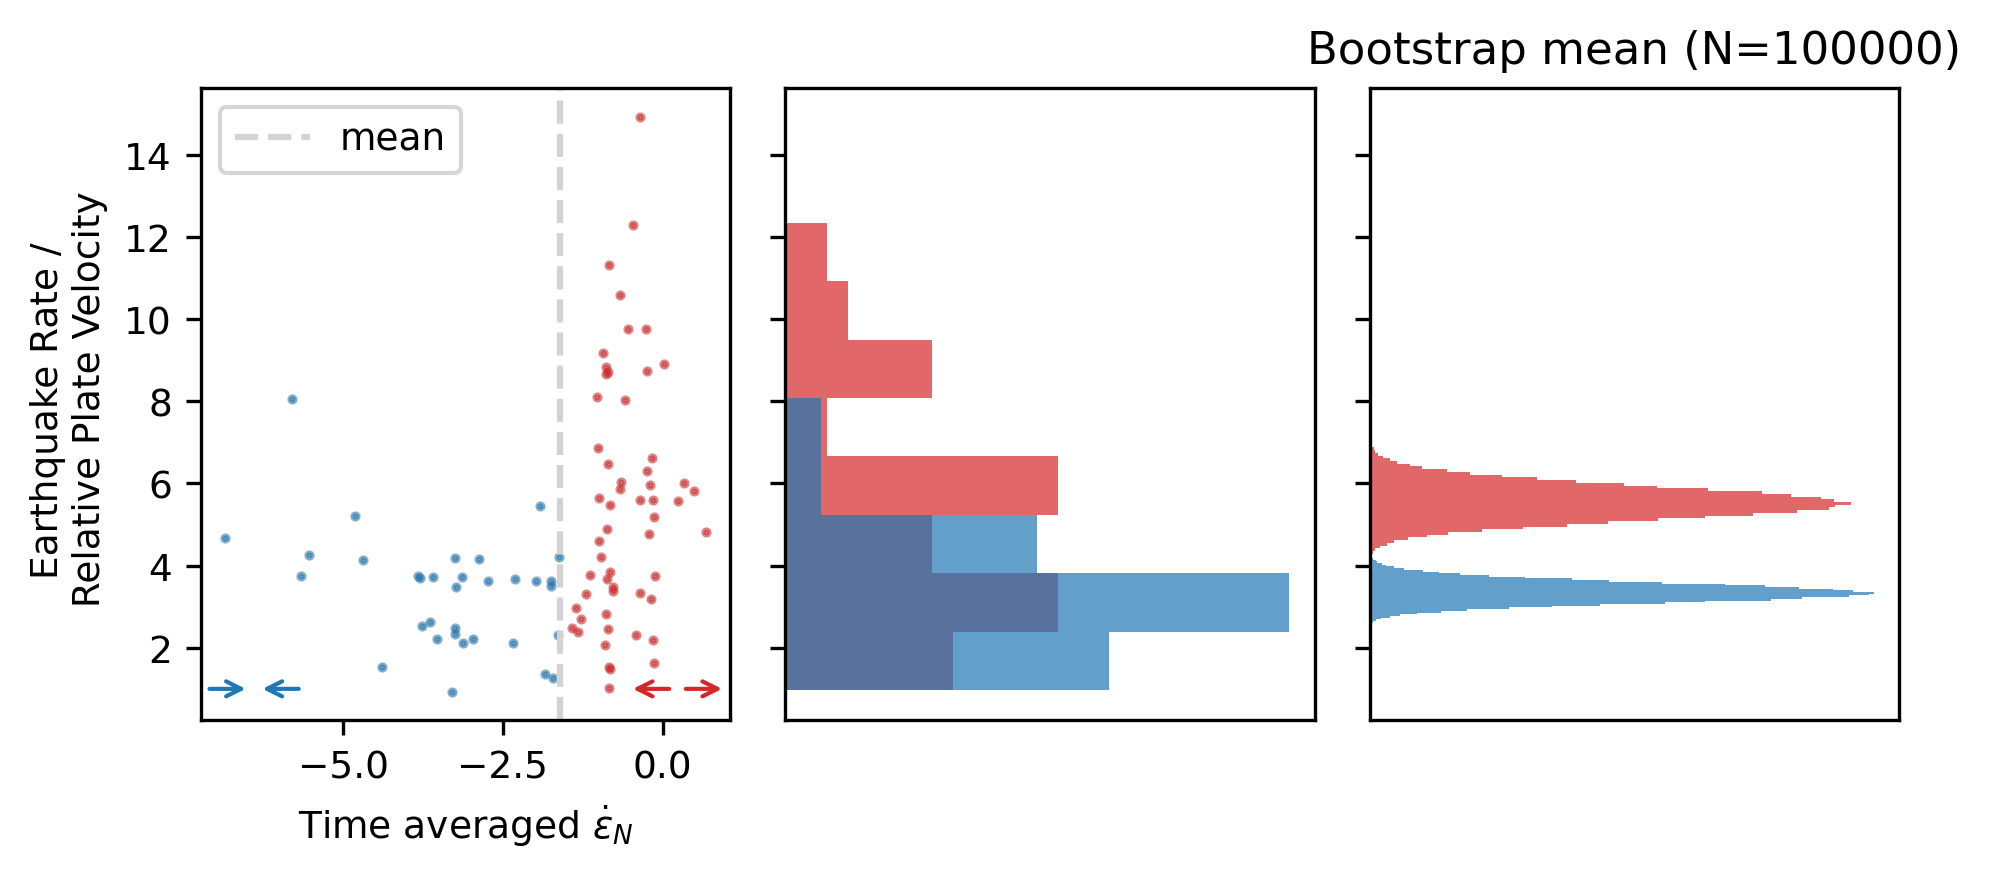

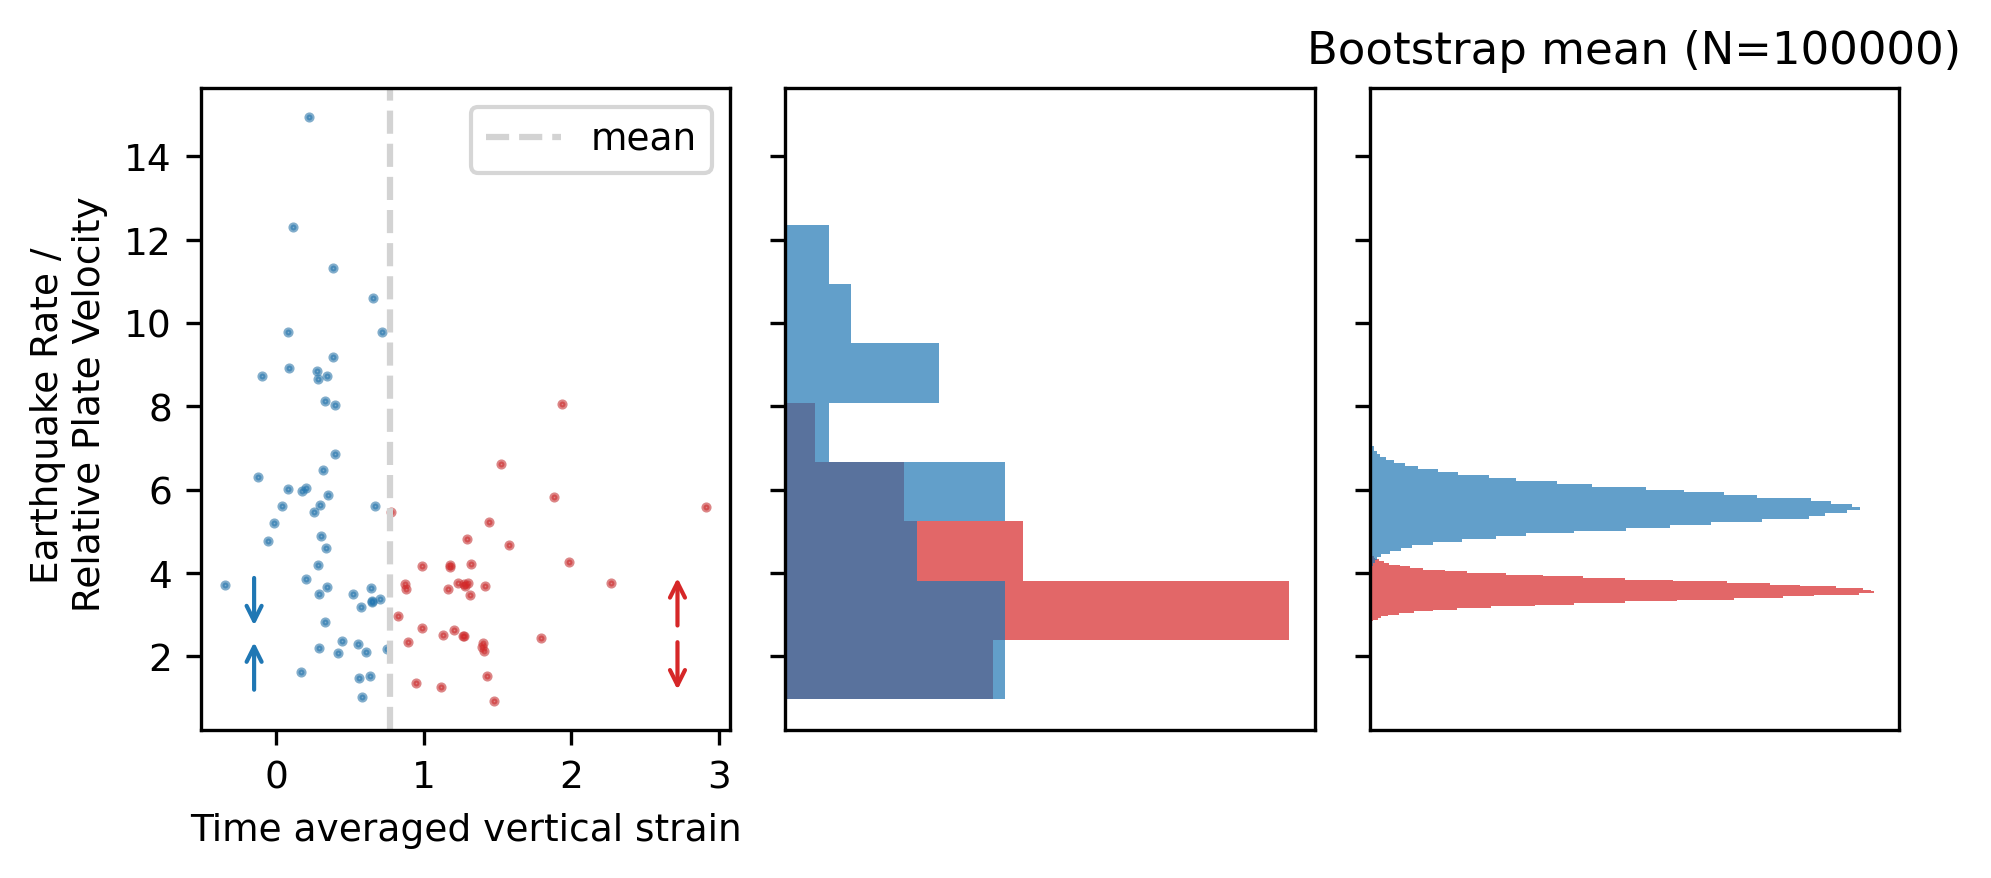

In [56]:
def summary_plot(x, y, cut, theshold=0, data_label=None):
    """
    Summary plot of the data.

    Parameters
    ----------
    x : array-like
        The data to plot.
    y : array-like
        The data to plot.
    cut : separates the 'high' and 'low' values of x.
    theshold : optional buffer around the cut.

    """

    fig, AX = plt.subplots(1, 3, sharey=True, figsize=(6.5, 3))
    ax = AX[0]

    # Labels are flipped pos/neg to match convention since strain is *-1
    positive_index = x > cut + theshold
    negative_index = x < cut - theshold
    ax.scatter(-x, y, s=2, alpha=0.1, c="k")
    ax.scatter(-x[negative_index], y[negative_index], s=2, alpha=0.5, color="C3")
    ax.scatter(-x[positive_index], y[positive_index], s=2, alpha=0.5)
    ax.set_xlabel(f"{data_label}")
    ax.set_ylabel("Earthquake Rate / \n Relative Plate Velocity")
    ax.axvline(-cut, c="lightgrey", ls="--", label="mean")
    ax.legend()

    ax = AX[1]
    range_95th_percentile = np.percentile(y, [0.5, 99.5])
    bins = np.linspace(*range_95th_percentile, 10)
    ax.hist(
        y[negative_index],
        bins=bins,
        orientation="horizontal",
        alpha=0.7,
        label="strain<{theshold}".format(theshold=cut - theshold),
        density=True,
        color="C3",
    )
    ax.hist(
        y[positive_index],
        bins=bins,
        orientation="horizontal",
        alpha=0.7,
        label="strain>{theshold}".format(theshold=cut + theshold),
        density=True,
    )

    ax.set(
        xticks=[],
    )

    ax = AX[2]
    number_of_bootstrap_samples = 100000

    negative_boot_sample = bootstrap_statistic(
        y[negative_index],
        np.mean,
        boot=number_of_bootstrap_samples,
    )

    positive_boot_sample = bootstrap_statistic(
        y[positive_index],
        np.mean,
        boot=number_of_bootstrap_samples,
    )

    ax.hist(
        negative_boot_sample,
        orientation="horizontal",
        alpha=0.7,
        bins=50,
        color="C3",
    )

    ax.hist(
        positive_boot_sample,
        orientation="horizontal",
        alpha=0.7,
        bins=50,
        color="C0",
    )

    ax.set(
        xticks=[],
        title="Bootstrap mean (N={number_of_bootstrap_samples})".format(
            number_of_bootstrap_samples=number_of_bootstrap_samples,
        ),
    )

    plt.tight_layout()
    
    return AX

def arrow_annotation(ax, y_pos=0.05, x_center=0.9, arrow_len=0.1, color="k", direction="outwards", orientation="horizontal"):

    if orientation == "horizontal":
        if direction == "outwards":
            # left-pointing arrow
            ax.annotate(
                "", xy=(x_center - arrow_len, y_pos), xycoords="axes fraction",
                xytext=(x_center, y_pos), textcoords="axes fraction",
                arrowprops=dict(arrowstyle="->", lw=1, color=color)
            )

            # right-pointing arrow
            ax.annotate(
                "", xy=(x_center + arrow_len, y_pos), xycoords="axes fraction",
                xytext=(x_center, y_pos), textcoords="axes fraction",
                arrowprops=dict(arrowstyle="->", lw=1, color=color)
            )
        elif direction == "inwards":
            # right-pointing arrow
            ax.annotate(
                "", xy=(x_center, y_pos), xycoords="axes fraction",
                xytext=(x_center - arrow_len, y_pos), textcoords="axes fraction",
                arrowprops=dict(arrowstyle="->", lw=1, color=color)
            )

            # left-pointing arrow
            ax.annotate(
                "", xy=(x_center, y_pos), xycoords="axes fraction",
                xytext=(x_center + arrow_len, y_pos), textcoords="axes fraction",
                arrowprops=dict(arrowstyle="->", lw=1, color=color)
            )
    elif orientation == "vertical":
        if direction == "outwards":
            # down-pointing arrow
            ax.annotate(
                "", xy=(x_center, y_pos - arrow_len), xycoords="axes fraction",
                xytext=(x_center, y_pos), textcoords="axes fraction",
                arrowprops=dict(arrowstyle="->", lw=1, color=color)
            )

            # up-pointing arrow
            ax.annotate(
                "", xy=(x_center, y_pos + arrow_len), xycoords="axes fraction",
                xytext=(x_center, y_pos), textcoords="axes fraction",
                arrowprops=dict(arrowstyle="->", lw=1, color=color)
            )
        elif direction == "inwards":
            # up-pointing arrow
            ax.annotate(
                "", xy=(x_center, y_pos), xycoords="axes fraction",
                xytext=(x_center, y_pos - arrow_len), textcoords="axes fraction",
                arrowprops=dict(arrowstyle="->", lw=1, color=color)
            )

            # down-pointing arrow
            ax.annotate(
                "", xy=(x_center, y_pos), xycoords="axes fraction",
                xytext=(x_center, y_pos + arrow_len), textcoords="axes fraction",
                arrowprops=dict(arrowstyle="->", lw=1, color=color)
            )


cut = np.mean(np.mean(normal_strain_grid, axis=1))
AX = summary_plot(
    np.mean(normal_strain_grid, axis=1),
    (rate / plate_boundary_velocity)[1:],
    cut,
    theshold=0,
    data_label=r"Time averaged $\dot{\epsilon}_N$",
)

arrow_annotation(AX[0], color="C3", direction="outwards", orientation="horizontal")
arrow_annotation(AX[0], color="C0", x_center=0.1, direction="inwards", orientation="horizontal")

cut = np.mean(np.mean(strain_at_plate_boundary_grid[:, :, 2, 2], axis=1))
AX = summary_plot(
    np.mean(strain_at_plate_boundary_grid[:, :, 2, 2][1:], axis=1),
    (rate / plate_boundary_velocity)[1:],
    cut,
    theshold=0,
    data_label="Time averaged vertical strain",
)

arrow_annotation(AX[0], color="C3", y_pos=0.15, direction="outwards", orientation="vertical")
arrow_annotation(AX[0], color="C0", y_pos=0.15, x_center=0.1, direction="inwards", orientation="vertical")

ax

**Figure**: Time averaged strain rate versus the normalized rate of seismicity. It does seem that, in agreement with expectation, the rate of seismicity tends to be higher in areas more GrGIA dilation (blue).

Figure: Here we just consider every single point on the MAR for every time step. The increased number points does increase the statistical significance. However, note that these so-called measurements are strongly correlated in space and time. I think we also need to be cautious about this more generally when using the bootstrap estimates. NOTE the y-axis is log-scaled. 

/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_49730/3055454020.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(


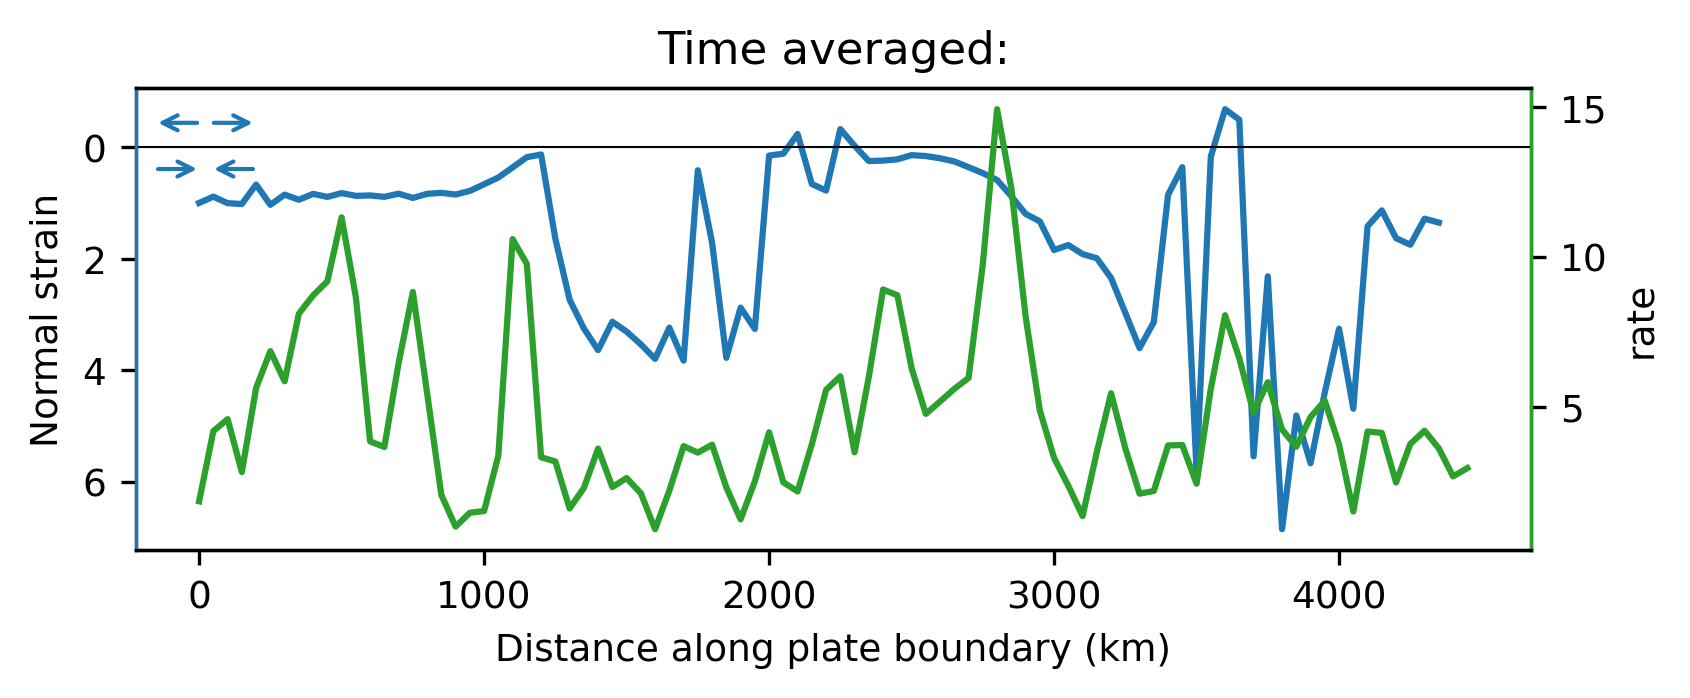

In [57]:
fig, ax = plt.subplots(figsize=(6, 2))

ax.plot(np.mean(normal_strain_grid, axis=1)[1:])
ax.axhline(0, c="k", lw=0.5)
ax.invert_yaxis()  # Invert the y-axis to increase downwards


axc = ax.twinx()
axc.plot(rate / plate_boundary_velocity, c="C2")
axc.spines["right"].set_edgecolor("C2")
axc.spines["left"].set_edgecolor("C0")
axc.set_ylabel("rate")

arrow_annotation(ax, color="C0", y_pos=0.925, x_center=0.05, arrow_len=0.04, direction="outwards")
arrow_annotation(ax, color="C0", y_pos=0.825, x_center=0.05, arrow_len=0.04, direction="inwards")

# NOTE THAT THE Y-AXIS IS INVERTED
ax.set(
    title="Time averaged:",
    xticklabels=[f"{v/1000:0.0f}" for v in ax.get_xticks()*plate_boundary_metadata['stepsize']],
    xlabel="Distance along plate boundary (km)",
    ylabel = "Normal strain",
);

/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_49730/4159995640.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  [iax.set_xticklabels(iax.get_xticklabels(), rotation = 45, ha="right") for iax in AX]


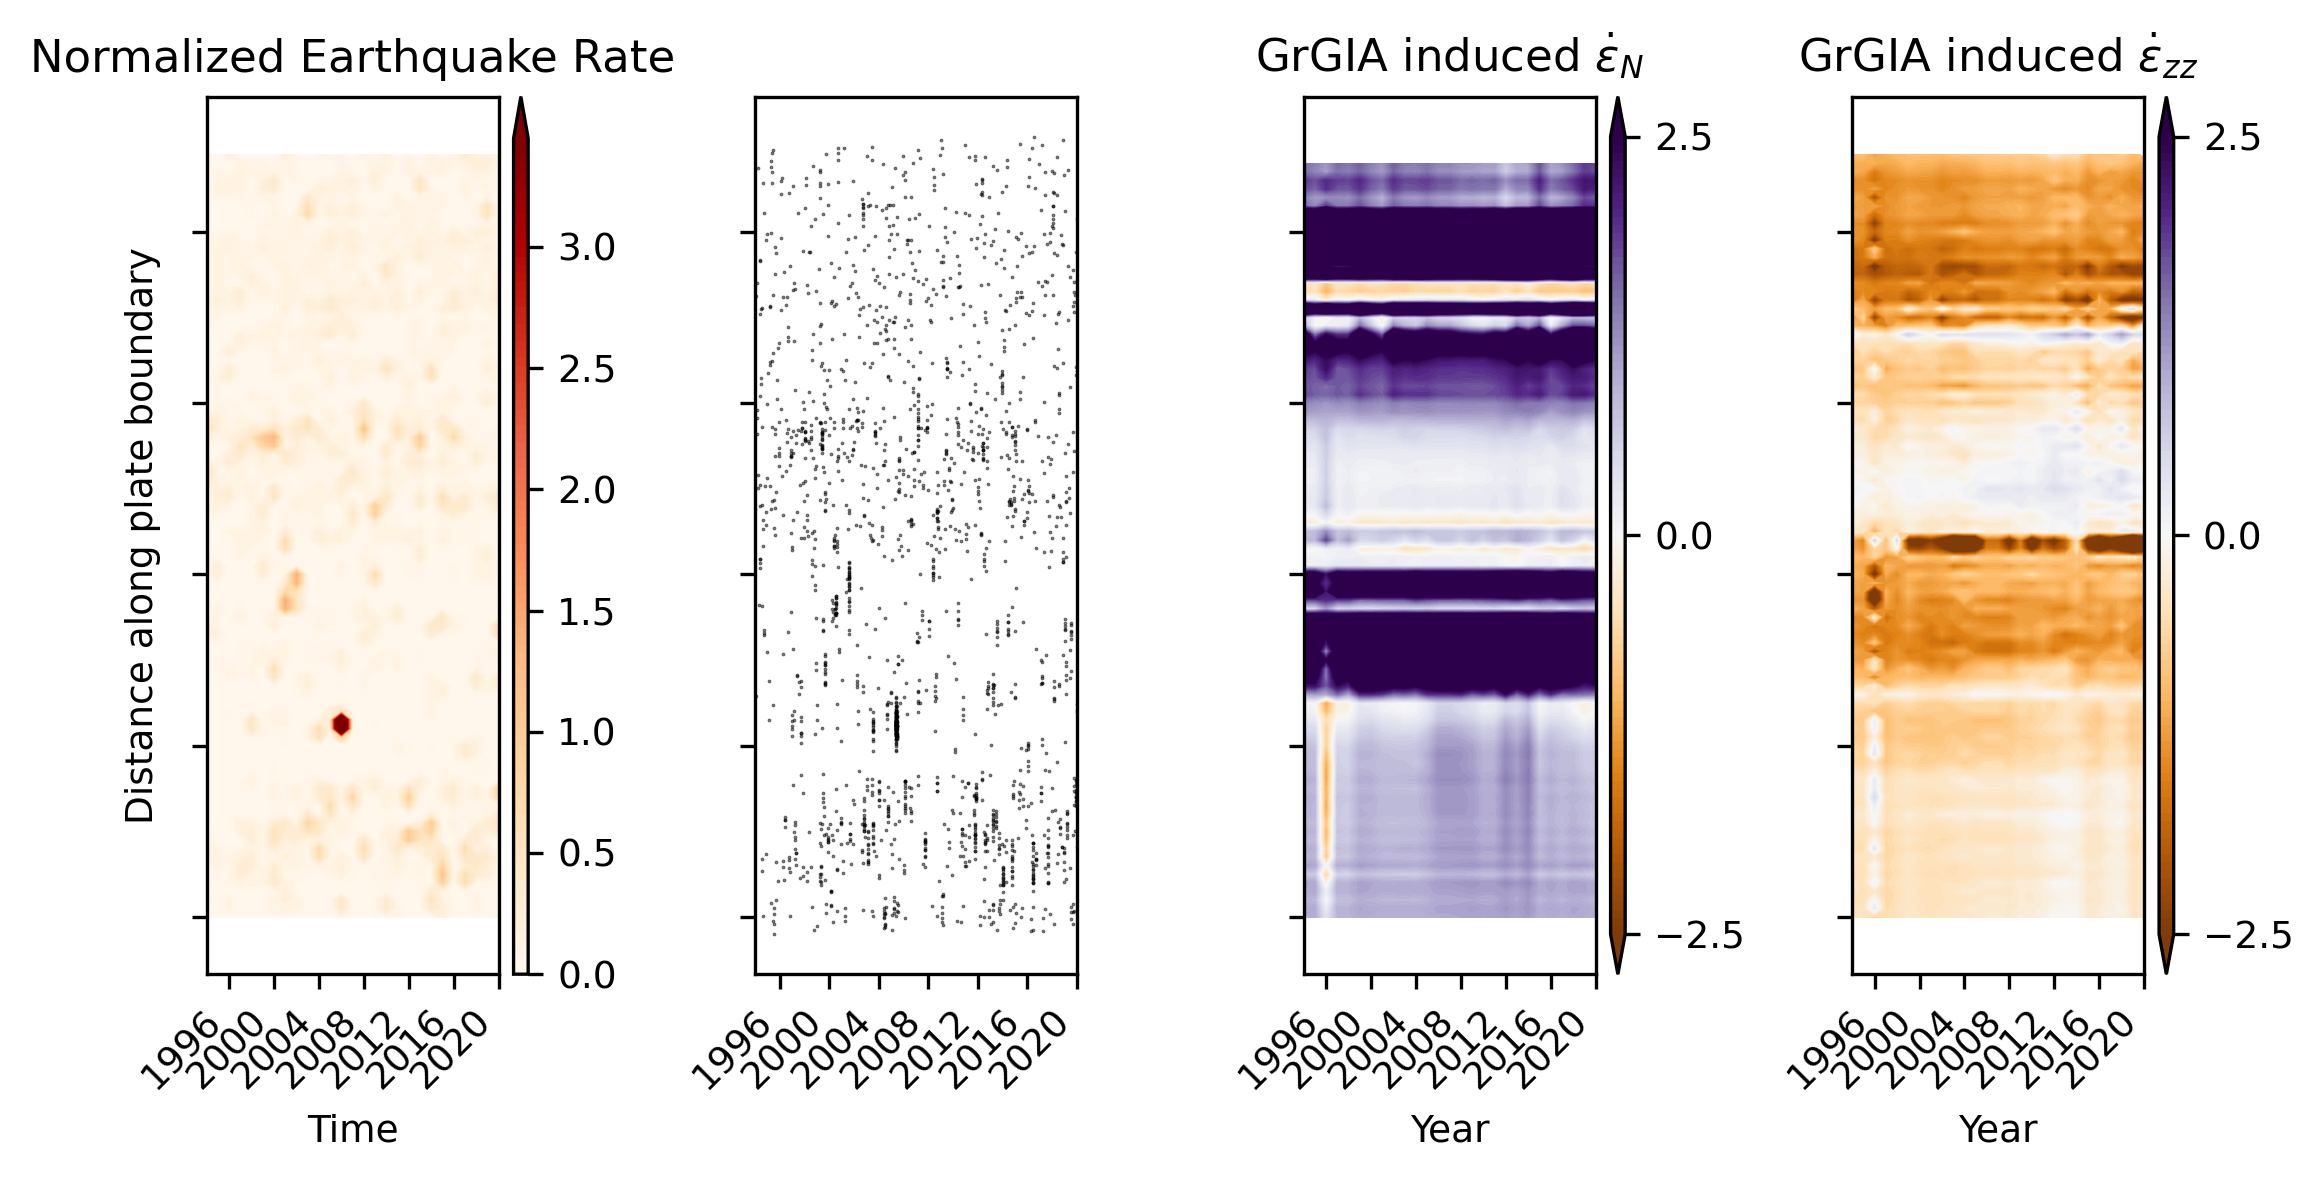

In [58]:
fig, AX = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(7.5, 4))

velocity_grid = np.expand_dims(plate_boundary_velocity, 1) * np.ones_like(gia.time)

ax = AX[0]
# plot the rate_grid of events over time and space
max_level = 0.5 * (rate_grid / velocity_grid).max()
levels = np.linspace((rate_grid / velocity_grid).min(), max_level, 100)
cf = ax.contourf(
    date_range[1:],
    np.arange(len(rate_grid)) * plate_boundary_metadata["stepsize"]/1000,
    rate_grid / velocity_grid,
    levels=levels,
    cmap="OrRd",
    vmax=max_level,
    extend="max",
    extent=[0, rate_grid.shape[1], 0, rate_grid.shape[0]],
)
x_lim = ax.get_xlim()

ax.set_xlabel("Time")
ax.set_ylabel("Distance along plate boundary")
ax.margins(x=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cf, cax=cax, ticks=np.arange(0, max_level, 0.5))

ax.set_title("Normalized Earthquake Rate")


ax = AX[1]
ax.scatter(
    catalog.time, catalog.distance_along_boundary/1000 + np.random.normal(0, 50, len(catalog)),
    color='black',
    s=0.5,
    lw=0.2,
    alpha=0.5, 
)


ax = AX[2]
color_range = [-2.5, 2.5]
im = ax.contourf(
    date_range[1:],
    np.arange(len(rate_grid) - 1) * plate_boundary_metadata["stepsize"]/1000,
    normal_strain_grid,
    levels=np.linspace(*color_range, 100),
    extend="both",
    extent=[0, rate_grid.shape[1], 0, rate_grid.shape[0]],
    cmap="PuOr",
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, ticks=[color_range[0], 0, color_range[1]])

ax.set_xlabel("Year")


ax.set_yticklabels([])
ax.set_title(r"GrGIA induced $\dot{\epsilon}_N$")

ax = AX[3]
color_range = [-2.5, 2.5]
im = ax.contourf(
    date_range[1:],
    np.arange(len(rate_grid)) * plate_boundary_metadata["stepsize"]/1000,
    strain_at_plate_boundary_grid[:, :, 2, 2],
    levels=np.linspace(*color_range, 100),
    extend="both",
    extent=[0, rate_grid.shape[1], 0, rate_grid.shape[0]],
    cmap="PuOr",
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, ticks=[color_range[0], 0, color_range[1]])

ax.set_xlabel("Year")


ax.set_yticklabels([])

ax.set_title(r"GrGIA induced $\dot{\epsilon}_{zz}$")

[iax.set(xlim=x_lim) for iax in AX]
[iax.set_xticklabels(iax.get_xticklabels(), rotation = 45, ha="right") for iax in AX]

plt.tight_layout()


/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_49730/1985896529.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


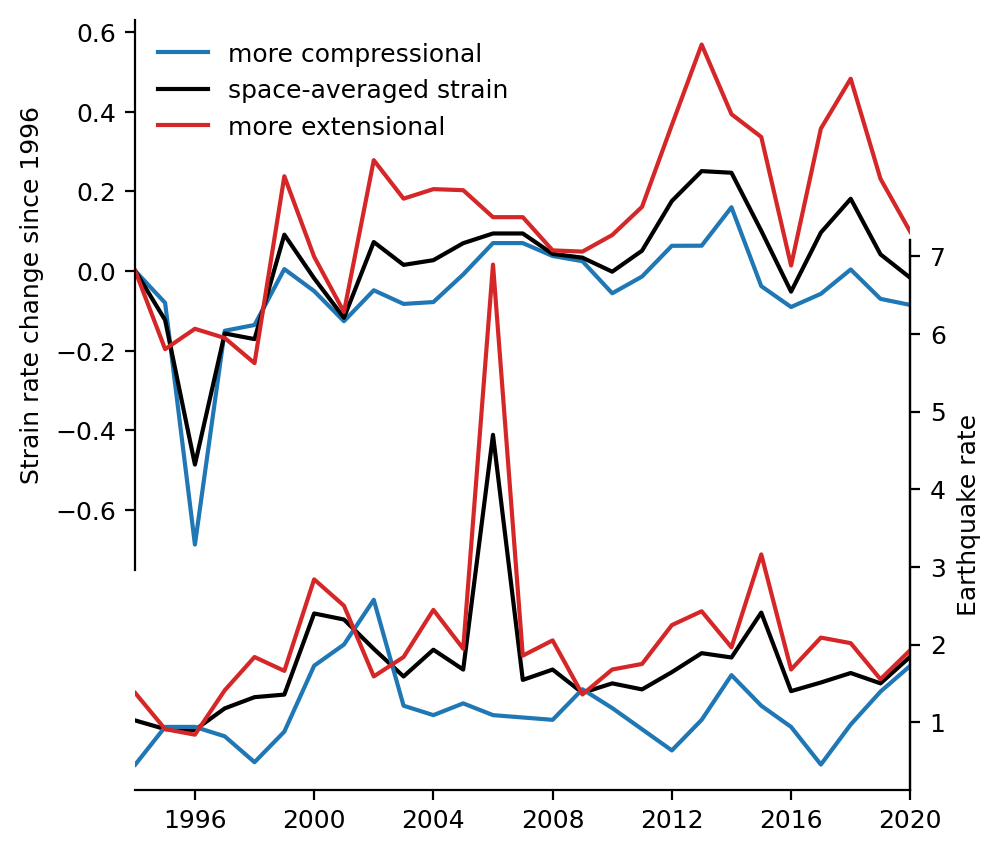

In [59]:
fig, AX = plt.subplots(2, 1, figsize=(5, 5), dpi=200, gridspec_kw={'hspace': -0.6})

extentional_indices = np.where(
    np.mean(normal_strain_grid, axis=1) < np.mean(normal_strain_grid)
)[0]
contraction_indices = np.where(
    np.mean(normal_strain_grid, axis=1) > np.mean(normal_strain_grid)
)[0]

# plot the space-averaged strain vs time
ax = AX[0]

# for row in normal_strain_grid:
#     ax.plot(date_range[1:], row - row[0], color="k", alpha=0.1)

v = np.mean(normal_strain_grid[extentional_indices, :], axis=0)
ax.plot(
    date_range[1:],
    v - v[0],
    label="more compressional",
    color="C0",
)

v = np.mean(normal_strain_grid, axis=0)
ax.plot(date_range[1:], v - v[0], color="k", label="space-averaged strain")

v = np.mean(normal_strain_grid[contraction_indices, :], axis=0)
ax.plot(
    date_range[1:],
    v - v[0],
    label="more extensional",
    color="C3",
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set(xticks=[], xlim=[date_range[1:].min(), date_range[1:].max()])

axb = AX[1].twinx()

axb.plot(
    date_range[1:],
    np.mean(rate_grid, axis=0),
    color="k",
)

axb.plot(
    date_range[1:],
    np.mean(rate_grid[contraction_indices, :], axis=0),
    color="C0",
    label="more compressional",
)

axb.plot(
    date_range[1:],
    np.mean(rate_grid[extentional_indices, :], axis=0),
    color="C3",
    label="more extensional",
)

axb.spines['top'].set_visible(False)
axb.spines['left'].set_visible(False)
AX[1].spines['top'].set_visible(False)
AX[1].spines['left'].set_visible(False)
AX[1].spines['bottom'].set_visible(False)
AX[1].set(yticks=[])
# remove facecolor
axb.set_facecolor('none')
AX[1].set_facecolor('none')

axb.set(xlabel="Year", ylabel="Earthquake rate", xlim=[date_range[1:].min(), date_range[1:].max()])
ax.set(ylabel="Strain rate change since 1996")

# top left legend
AX[0].legend(
    loc='upper left',
    frameon=False
)

plt.tight_layout()